In [90]:
# basics + plotting
import importlib
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams["figure.dpi"] = 250
plt.rcParams["font.family"] = "sans serif"

import matplotlib as mpl

In [4]:
def get_fields(fields, base_dir):
    
    print(f"fetching field {fields[0]} ...", end=" ")
    df = pd.read_csv(os.path.join(base_dir, fields[0] + '.csv'), 
                     low_memory=False, dtype=str)\
            .set_index('eid')
    df = (df + '_').fillna('').sum(1).str[:-1].to_frame(name=fields[0])
    print("Done")
    
    for f in fields[1:]:
        print(f"fetching field {f} ...", end=" ")
        df_ = pd.read_csv(os.path.join(base_dir, f + '.csv'), 
                          low_memory=False, dtype=str)\
                .set_index('eid')
        df_ = (df_ + '_').fillna('').sum(1).str[:-1]
        
        df = pd.merge(left=df,
                      right=df_.to_frame(name=f),
                      left_index=True, 
                      right_index=True, 
                      how='inner')
        print("Done")
        
    return df

### Preparing demographic data

In [204]:
# read basic demographic info fields
demographic_info = [
    "21000", # ethnicity
    "34" # year of birth
]
dem = get_fields(demographic_info, "../../../../all_phenotyes_aug2022/split_phenotypes")

# fix typing
dem['34'] = dem['34'].replace({'':np.nan}).astype(float)

# select the most recent ethnicity check
dem['21000'] = dem['21000'].str.split('_').apply(lambda x: x[-1])

# replace empty entries with '-1', UKBB data coding 1001 for unknown ethnicity
dem['21000'] = dem['21000'].replace({'':'-1'})
dem['21000'] = dem['21000'].astype(int)

# rename columns
dem = dem.rename(columns={'21000':'ethnicity', '34':'yob'})

fetching field 21000 ... Done
fetching field 34 ... Done


In [206]:
# read UKBB data coding 1001 table
coding1001 = pd.read_table('coding1001.tsv')
code_to_meaning = coding1001[['coding', 'meaning']].set_index('coding').to_dict()['meaning']

In [207]:
coding1001

,coding,meaning,node_id,parent_id,selectable
0,-3,Prefer not to answer,-3,0,Y
1,-1,Do not know,-1,0,Y
2,1,White,1,0,Y
3,2,Mixed,2,0,Y
4,3,Asian or Asian British,3,0,Y
5,4,Black or Black British,4,0,Y
6,5,Chinese,5,0,Y
7,6,Other ethnic group,6,0,Y
8,1001,British,1001,1,Y
9,1002,Irish,1002,1,Y


In [262]:
ethnicity_counts = pd.merge(left=coding1001,
                            right=dem['ethnicity'].value_counts(),
                            left_on='coding',
                            right_index=True)
ethnicity_counts.iloc[2:8, 3] = ethnicity_counts.iloc[2:8, 2]
ethnicity_counts = ethnicity_counts.sort_values(['parent_id', 'ethnicity'], ascending=[True, False])

In [263]:
ethnicity_counts

,coding,meaning,node_id,parent_id,selectable,ethnicity
0,-3,Prefer not to answer,-3,0,Y,1652
1,-1,Do not know,-1,0,Y,1112
8,1001,British,1001,1,Y,442664
10,1003,Any other white background,1003,1,Y,16250
9,1002,Irish,1002,1,Y,13154
2,1,White,1,1,Y,556
14,2004,Any other mixed background,2004,2,Y,1040
13,2003,White and Asian,2003,2,Y,829
11,2001,White and Black Caribbean,2001,2,Y,620
12,2002,White and Black African,2002,2,Y,423


#### Plotting ethnic breakdown

In [211]:
cmap = mpl.colormaps['tab10']

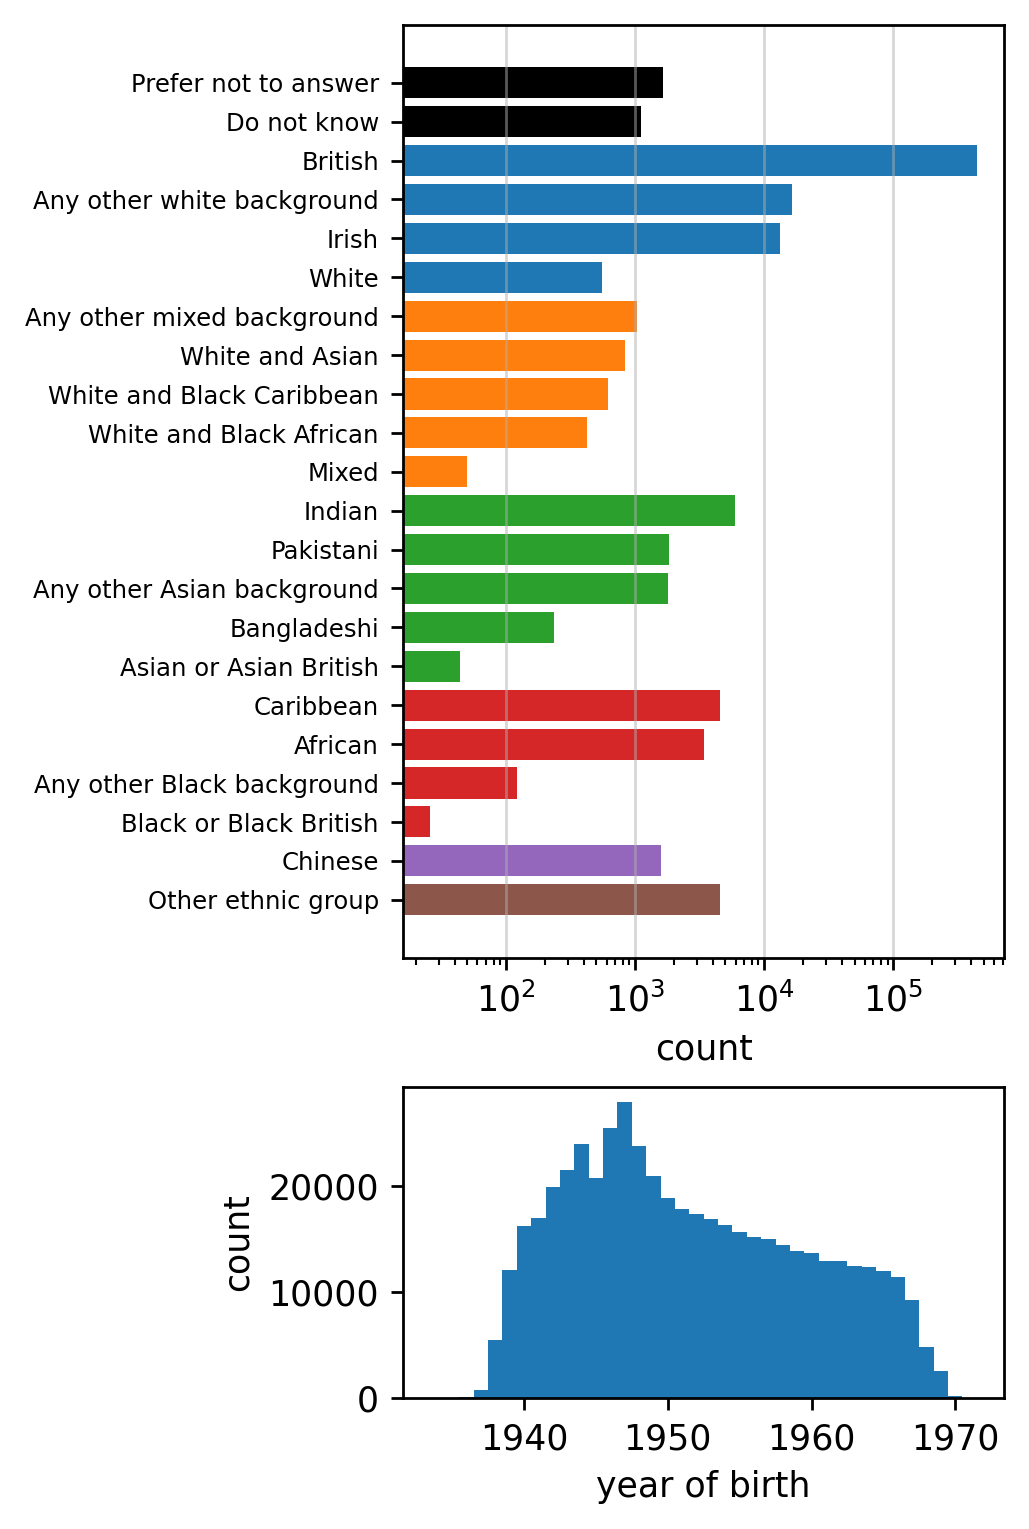

In [265]:
fig, axes = plt.subplots(2,1,figsize=(4,6), gridspec_kw={'height_ratios':[3,1]}, constrained_layout=True)

ax = axes[0]
ax.barh(ethnicity_counts['meaning'],
        ethnicity_counts['ethnicity'],
        color = [cmap(i-1) if i!=0 else 'k' for i in ethnicity_counts['parent_id']])
        

ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=7)
ax.grid(axis='x', alpha=0.5)
ax.set_xlabel('count')
ax.invert_yaxis()

ax = axes[1]
ax.hist(dem['yob'], 
        bins = np.arange(dem['yob'].min()-0.5, dem['yob'].max()+1, 1));
ax.set_xlabel('year of birth')
ax.set_ylabel('count')

fig.savefig('../figures/ethnicity_yob_breakdown.png')

### Preparing cases and controls

In [277]:
diagnosis_fields = [
    "131338", # date first diagnosed with I42
    "41202", # ICD10 diagnoses
    "41204", # ICD10 diagnoses
    "41270", # ICD10 diagnoses
    "20002", # self-reported conditions
    "40001", # primary cause of death
    "40002"  # secondary cause of death
]

In [278]:
dx = get_fields(diagnosis_fields, "../../../../all_phenotyes_aug2022/split_phenotypes")

# merge all ICD 10 columns into one
dx['all_icd10']=(dx[['41202', 
                     '41204', 
                     '41270', 
                     '40001', 
                     '40002']] + '_').sum(axis=1)

fetching field 131338 ... Done
fetching field 41202 ... Done
fetching field 41204 ... Done
fetching field 41270 ... Done
fetching field 20002 ... Done
fetching field 40001 ... Done
fetching field 40002 ... Done


In [279]:
dx

,131338,41202,41204,41270,20002,40001,40002,all_icd10
eid,,,,,,,,
1000015,,H258_R074,H184_H522_R060_Z721,H184_H258_H522_R060_R074_Z721,,,,H258_R074_H184_H522_R060_Z721_H184_H258_H522_R...
1000027,,D123_I803_K635,D125_I831_K621_K635,D123_D125_I803_I831_K621_K635,1651_1568,,,D123_I803_K635_D125_I831_K621_K635_D123_D125_I...
1000039,,B349_K049_M674_O342_O990,D509_O692_R011_R102_Z370_Z874,B349_D509_K049_M674_O342_O692_O990_R011_R102_Z...,1078_1286,,,B349_K049_M674_O342_O990_D509_O692_R011_R102_Z...
1000040,,C443_K573_M169,I849_L814_Z501,C443_I849_K573_L814_M169_Z501,,,,C443_K573_M169_I849_L814_Z501_C443_I849_K573_L...
1000053,,M2331,M170,M170_M2331,1111_1452_1387_1538,,,M2331_M170_M170_M2331___
...,...,...,...,...,...,...,...,...
6025195,,I200_I209_I251_I269_R060_R073_R074,E780_I200_I48_M4199_M8199_N390_R002_R074_R42_Z...,E780_I200_I209_I251_I269_I48_M4199_M8199_N390_...,1074_1538_1398_1353_1138_1426,,,I200_I209_I251_I269_R060_R073_R074_E780_I200_I...
6025207,,H251_R31,H010_I10_M139_N394_Z835_Z866_Z888_Z910_Z922,H010_H251_I10_M139_N394_R31_Z835_Z866_Z888_Z91...,,,,H251_R31_H010_I10_M139_N394_Z835_Z866_Z888_Z91...
6025210,,,,,,,,_____


In [280]:
def filter_cases_controls(df, 
                          inc_cases, # field:pattern to include in cases
                          exc_controls): # field:pattern to exclude from controls
    
    cases = pd.concat([df[k].str.contains(v) for k,v in inc_cases.items()], 
                      axis=1, 
                      ignore_index=False).any(1)
    controls = pd.concat([~df[k].str.contains(v) for k,v in exc_controls.items()], 
                          axis=1, 
                          ignore_index=False).all(1)
    return cases, controls

inc_cases = {
    'all_icd10': 'I42[1|2]',
    '20002': '1654'
}
exc_controls = {
    'all_icd10': 'I|G7[12]',
    '20002': '109[123456]|108[12]'
}
    
cases, controls = filter_cases_controls(dx, inc_cases, exc_controls)
print(cases.sum(), controls.sum())
dx['hcm'] = cases.astype(int)
dx = dx[(cases + controls)]

1168 271287


In [281]:
dx

,131338,41202,41204,41270,20002,40001,40002,all_icd10,hcm
eid,,,,,,,,,
1000015,,H258_R074,H184_H522_R060_Z721,H184_H258_H522_R060_R074_Z721,,,,H258_R074_H184_H522_R060_Z721_H184_H258_H522_R...,0
1000039,,B349_K049_M674_O342_O990,D509_O692_R011_R102_Z370_Z874,B349_D509_K049_M674_O342_O692_O990_R011_R102_Z...,1078_1286,,,B349_K049_M674_O342_O990_D509_O692_R011_R102_Z...,0
1000053,,M2331,M170,M170_M2331,1111_1452_1387_1538,,,M2331_M170_M170_M2331___,0
1000071,,D250_K922_M171_N841_S5250,J459_J939_N950_N952_W199,D250_J459_J939_K922_M171_N841_N950_N952_S5250_...,1111,K256,,D250_K922_M171_N841_S5250_J459_J939_N950_N952_...,0
1000096,,A099_K572_M5494,K579_N832_N888_Z115_Z861_Z880_Z907,A099_K572_K579_M5494_N832_N888_Z115_Z861_Z880_...,,,,A099_K572_M5494_K579_N832_N888_Z115_Z861_Z880_...,0
...,...,...,...,...,...,...,...,...,...
6025162,,M161,,M161,,,,M161__M161___,0
6025186,,D126_J350_J36_K529_K589_K900_M161_M2557_R074_Z090,D124_D510_E039_K298_K529_K635_Z824_Z871_Z966,D124_D126_D510_E039_J350_J36_K298_K529_K589_K6...,1226_1331,,,D126_J350_J36_K529_K589_K900_M161_M2557_R074_Z...,0
6025210,,,,,,,,_____,0


In [283]:
dxdem = pd.merge(left=dx,
              right=dem,
              left_index=True,
              right_index=True,
              how='inner')
# remove samples with unknown birth year
data = dxdem[['hcm', 
           'ethnicity', 
           'yob']][~dxdem['yob'].isna()]
data = data.astype({'yob':int})

# simplify ethnicity
data['ethnicity'] = data['ethnicity'].astype(str).str[0].replace({'-':'0'}).astype(int)

# save as parquet
data.to_parquet("../data/phenotypes_hcm_only.parquet")

### Prepare lab measurements data

In [295]:
measurement_fields = [
    "22420", # LV ejection fraction
    "22421", # LV end diastolic volume
    "22422", # LV end systolic volume
    "22423", # LV stroke volume
    "22424", # Cardiac output
    "22425", # Cardiac index
    "22426", # Average heart rate
    "22427", # Body surface area
    "24105", # LV myocardial mass
    "24157", # LV circumferential strain global
    "24181", # LV longitudinal strain global
    "24140", # LV mean myocardial wall thickness global
    "24174", # LV radial strain global
]

In [ ]:
# TODO